# Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data preprocessing

### Data collection

In [2]:
df = pd.read_csv('data/freedom_index.csv')

In [3]:
df

,country,region,score,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom
0,Singapore,Asia-Pacific,83.5,94.2,88.3,58.3,90.7,89.2,76.0,86.9,77.3,76.3,95.0,90.0,80.0
1,Switzerland,Europe,83.0,94.2,91.3,98.1,70.4,64.6,95.7,89.3,60.7,80.8,86.4,85.0,80.0
2,Ireland,Europe,82.6,93.5,83.4,94.3,78.0,82.4,91.7,91.3,62.8,74.5,79.2,90.0,70.0
3,Taiwan,Asia-Pacific,80.0,82.2,73.4,94.0,79.2,90.5,90.3,84.9,69.1,80.1,86.4,70.0,60.0
4,Luxembourg,Europe,79.2,96.9,84.9,95.8,64.6,40.6,97.6,89.5,57.7,69.1,79.2,95.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Liechtenstein,Europe,NaN,92.8,82.4,86.0,NaN,NaN,NaN,88.2,NaN,NaN,86.4,80.0,80.0
180,Somalia,Sub-Saharan Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181,Syria,Middle East/North Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,Ukraine,Europe,NaN,23.0,32.5,30.4,NaN,NaN,NaN,NaN,NaN,NaN,73.2,NaN,NaN


In [4]:
df.describe()

,score,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom
count,176.000000,182.000000,182.000000,182.000000,177.000000,176.000000,176.000000,177.000000,176.000000,176.000000,178.000000,177.000000,177.000000
mean,58.643182,53.597802,43.889560,48.937363,78.189831,64.036932,52.180682,62.323164,56.105114,67.590909,69.924719,56.440678,48.757062
std,11.153232,25.121679,21.897394,27.449579,12.931072,25.186746,33.724461,17.369644,10.690553,14.066586,12.191873,20.644120,18.575178
min,2.900000,0.000000,3.600000,3.300000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,51.975000,35.475000,27.550000,28.100000,72.500000,48.575000,19.200000,49.400000,51.250000,66.475000,63.700000,45.000000,30.000000
50%,58.800000,49.150000,40.250000,44.950000,79.000000,70.250000,62.500000,65.500000,57.050000,70.900000,71.800000,60.000000,50.000000
75%,65.750000,72.450000,58.375000,71.375000,86.900000,82.850000,82.450000,75.500000,62.650000,74.425000,79.200000,70.000000,60.000000
max,83.500000,100.000000,97.400000,98.100000,100.000000,97.500000,100.000000,92.700000,78.900000,81.900000,95.000000,95.000000,90.000000


### Data cleansing

#### Drop unuse columns

In [5]:
unused_cols = ['country']

In [6]:
df = df.drop(columns=unused_cols)

#### Define target

In [7]:
target = 'score'

<Axes: >

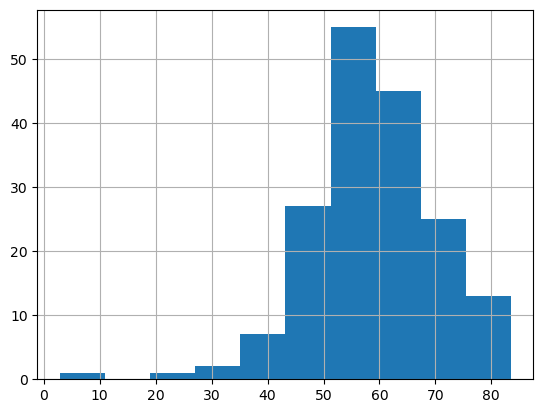

In [8]:
df[target].hist()

#### Check data type

In [9]:
df.dtypes

region                     object
score                     float64
property_rights           float64
government_integrity      float64
judicial_effectiveness    float64
tax_burden                float64
government_spending       float64
fiscal_health             float64
business_freedom          float64
labor_freedom             float64
monetary_freedom          float64
trade_freedom             float64
investment_freedom        float64
financial_freedom         float64
dtype: object

#### Clean missing value

In [10]:
df.isnull().sum()

region                    0
score                     8
property_rights           2
government_integrity      2
judicial_effectiveness    2
tax_burden                7
government_spending       8
fiscal_health             8
business_freedom          7
labor_freedom             8
monetary_freedom          8
trade_freedom             6
investment_freedom        7
financial_freedom         7
dtype: int64

In [11]:
group_cols = ['region']

# Drop rows with no target value.
df = df.dropna(subset=[target])

for col in [x for x in df.columns if x not in group_cols + ['target']]:
    if (df[col].dtype == 'int64') | (df[col].dtype == 'float64'):
        # Fill mean value of its category for number columns.
        df.loc[:, col] = df.groupby(group_cols)[col].transform(
            lambda x: x.fillna(x.mean())
        )
    elif df[col].dtype == 'object':
        # Fill most common value of its category for catgorical columns.
        df.loc[:, col] = df.groupby(group_cols)[col].transform(
            lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x
        )

In [12]:
df

,region,score,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom
0,Asia-Pacific,83.5,94.2,88.3,58.3,90.7,89.2,76.0,86.9,77.3,76.3,95.0,90.0,80.0
1,Europe,83.0,94.2,91.3,98.1,70.4,64.6,95.7,89.3,60.7,80.8,86.4,85.0,80.0
2,Europe,82.6,93.5,83.4,94.3,78.0,82.4,91.7,91.3,62.8,74.5,79.2,90.0,70.0
3,Asia-Pacific,80.0,82.2,73.4,94.0,79.2,90.5,90.3,84.9,69.1,80.1,86.4,70.0,60.0
4,Europe,79.2,96.9,84.9,95.8,64.6,40.6,97.6,89.5,57.7,69.1,79.2,95.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Sub-Saharan Africa,38.2,20.2,19.8,16.0,74.6,92.1,78.5,39.0,32.8,0.0,50.4,25.0,10.0
172,Sub-Saharan Africa,33.9,12.5,19.5,4.8,85.0,95.1,66.5,27.7,41.8,0.0,29.6,5.0,20.0
173,Americas,28.1,0.0,6.4,3.3,75.9,96.6,36.5,31.0,35.7,0.0,42.2,0.0,10.0
174,Americas,25.7,30.1,36.2,15.2,51.9,0.0,0.0,41.5,20.0,20.3,72.8,10.0,10.0


#### Transform categorical columns

In [13]:
cate_cols = ['region']
df = pd.get_dummies(df, columns=cate_cols, prefix=cate_cols, drop_first=True)

In [14]:
df

,score,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom,region_Asia-Pacific,region_Europe,region_Middle East/North Africa,region_Sub-Saharan Africa
0,83.5,94.2,88.3,58.3,90.7,89.2,76.0,86.9,77.3,76.3,95.0,90.0,80.0,True,False,False,False
1,83.0,94.2,91.3,98.1,70.4,64.6,95.7,89.3,60.7,80.8,86.4,85.0,80.0,False,True,False,False
2,82.6,93.5,83.4,94.3,78.0,82.4,91.7,91.3,62.8,74.5,79.2,90.0,70.0,False,True,False,False
3,80.0,82.2,73.4,94.0,79.2,90.5,90.3,84.9,69.1,80.1,86.4,70.0,60.0,True,False,False,False
4,79.2,96.9,84.9,95.8,64.6,40.6,97.6,89.5,57.7,69.1,79.2,95.0,80.0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,38.2,20.2,19.8,16.0,74.6,92.1,78.5,39.0,32.8,0.0,50.4,25.0,10.0,False,False,False,True
172,33.9,12.5,19.5,4.8,85.0,95.1,66.5,27.7,41.8,0.0,29.6,5.0,20.0,False,False,False,True
173,28.1,0.0,6.4,3.3,75.9,96.6,36.5,31.0,35.7,0.0,42.2,0.0,10.0,False,False,False,False
174,25.7,30.1,36.2,15.2,51.9,0.0,0.0,41.5,20.0,20.3,72.8,10.0,10.0,False,False,False,False


In [15]:
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [16]:
df

,score,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom,region_Asia-Pacific,region_Europe,region_Middle East/North Africa,region_Sub-Saharan Africa
0,83.5,94.2,88.3,58.3,90.7,89.2,76.0,86.9,77.3,76.3,95.0,90.0,80.0,1,0,0,0
1,83.0,94.2,91.3,98.1,70.4,64.6,95.7,89.3,60.7,80.8,86.4,85.0,80.0,0,1,0,0
2,82.6,93.5,83.4,94.3,78.0,82.4,91.7,91.3,62.8,74.5,79.2,90.0,70.0,0,1,0,0
3,80.0,82.2,73.4,94.0,79.2,90.5,90.3,84.9,69.1,80.1,86.4,70.0,60.0,1,0,0,0
4,79.2,96.9,84.9,95.8,64.6,40.6,97.6,89.5,57.7,69.1,79.2,95.0,80.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,38.2,20.2,19.8,16.0,74.6,92.1,78.5,39.0,32.8,0.0,50.4,25.0,10.0,0,0,0,1
172,33.9,12.5,19.5,4.8,85.0,95.1,66.5,27.7,41.8,0.0,29.6,5.0,20.0,0,0,0,1
173,28.1,0.0,6.4,3.3,75.9,96.6,36.5,31.0,35.7,0.0,42.2,0.0,10.0,0,0,0,0
174,25.7,30.1,36.2,15.2,51.9,0.0,0.0,41.5,20.0,20.3,72.8,10.0,10.0,0,0,0,0


#### Assign target and features

In [17]:
features = [x for x in df.columns if x != target]

In [18]:
features

['property_rights',
 'government_integrity',
 'judicial_effectiveness',
 'tax_burden',
 'government_spending',
 'fiscal_health',
 'business_freedom',
 'labor_freedom',
 'monetary_freedom',
 'trade_freedom',
 'investment_freedom',
 'financial_freedom',
 'region_Asia-Pacific',
 'region_Europe',
 'region_Middle East/North Africa',
 'region_Sub-Saharan Africa']

In [19]:
y = df[target]
X = df[features]

In [20]:
y

0      83.5
1      83.0
2      82.6
3      80.0
4      79.2
       ... 
171    38.2
172    33.9
173    28.1
174    25.7
175     2.9
Name: score, Length: 176, dtype: float64

In [21]:
X

,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom,region_Asia-Pacific,region_Europe,region_Middle East/North Africa,region_Sub-Saharan Africa
0,94.2,88.3,58.3,90.7,89.2,76.0,86.9,77.3,76.3,95.0,90.0,80.0,1,0,0,0
1,94.2,91.3,98.1,70.4,64.6,95.7,89.3,60.7,80.8,86.4,85.0,80.0,0,1,0,0
2,93.5,83.4,94.3,78.0,82.4,91.7,91.3,62.8,74.5,79.2,90.0,70.0,0,1,0,0
3,82.2,73.4,94.0,79.2,90.5,90.3,84.9,69.1,80.1,86.4,70.0,60.0,1,0,0,0
4,96.9,84.9,95.8,64.6,40.6,97.6,89.5,57.7,69.1,79.2,95.0,80.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,20.2,19.8,16.0,74.6,92.1,78.5,39.0,32.8,0.0,50.4,25.0,10.0,0,0,0,1
172,12.5,19.5,4.8,85.0,95.1,66.5,27.7,41.8,0.0,29.6,5.0,20.0,0,0,0,1
173,0.0,6.4,3.3,75.9,96.6,36.5,31.0,35.7,0.0,42.2,0.0,10.0,0,0,0,0
174,30.1,36.2,15.2,51.9,0.0,0.0,41.5,20.0,20.3,72.8,10.0,10.0,0,0,0,0


### Split dataset

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
X_train

,property_rights,government_integrity,judicial_effectiveness,tax_burden,government_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,trade_freedom,investment_freedom,financial_freedom,region_Asia-Pacific,region_Europe,region_Middle East/North Africa,region_Sub-Saharan Africa
152,22.1,33.0,11.1,90.1,58.8,83.6,52.9,46.3,62.2,70.8,30.0,20.0,0,1,0,0
128,37.7,35.6,43.7,84.3,78.1,68.5,60.5,48.2,70.0,58.2,10.0,30.0,1,0,0,0
104,31.4,26.2,27.6,83.6,83.7,89.3,49.9,50.0,67.5,49.8,60.0,50.0,0,0,0,1
78,72.0,72.1,65.2,79.1,54.6,12.4,76.9,50.8,77.0,80.2,55.0,30.0,0,0,0,1
36,65.4,58.7,76.9,78.9,86.9,44.4,79.5,61.8,74.5,75.0,60.0,50.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,34.1,41.4,71.5,82.0,78.5,64.7,67.2,64.1,70.9,55.2,55.0,50.0,0,0,0,0
106,41.0,18.6,22.0,88.8,78.2,74.7,54.7,47.4,71.5,70.8,50.0,50.0,1,0,0,0
14,89.1,68.0,74.4,76.8,55.5,83.2,80.7,61.8,66.5,79.2,70.0,70.0,0,1,0,0
92,55.3,36.2,45.4,79.3,84.3,62.5,49.0,47.6,60.0,64.4,65.0,50.0,0,0,0,1


In [24]:
y_train

152    48.4
128    52.1
104    55.8
78     60.4
36     67.7
       ... 
71     61.2
106    55.6
14     72.9
92     58.2
102    55.9
Name: score, Length: 123, dtype: float64

### Feature selection

#### Step-wise

In [25]:
def stepwise(X, y, threshold_in=0.05, threshold_out=0.05):
    """
    Stepwise regression for Linear Regression model.
    """
    included = []
    
    while True:
        changed = False
        
        # Forward Step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        best_pval = new_pval.min()
        
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            
            print(f'Add {best_feature} with p-value {best_pval}')
        
        # Backward Step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            
            print(f'Drop {worst_feature} with p-value {worst_pval}')
        
        if not changed:
            break

    return included

In [26]:
features = stepwise(X_train, y_train)

Add business_freedom with p-value 5.317596915885193e-40
Add investment_freedom with p-value 1.1311714011168853e-09
Add fiscal_health with p-value 6.915652554842316e-12
Add labor_freedom with p-value 1.1062405066092013e-11
Add monetary_freedom with p-value 3.728047688696007e-07
Add government_integrity with p-value 6.192160613356174e-11
Add government_spending with p-value 2.246145899803767e-16
Add property_rights with p-value 3.456654963395495e-09
Add tax_burden with p-value 7.841347601867866e-11
Add judicial_effectiveness with p-value 1.2254082871910952e-13
Add financial_freedom with p-value 7.370907176915558e-19
Add trade_freedom with p-value 4.97712495476068e-155


In [27]:
features

['business_freedom',
 'investment_freedom',
 'fiscal_health',
 'labor_freedom',
 'monetary_freedom',
 'government_integrity',
 'government_spending',
 'property_rights',
 'tax_burden',
 'judicial_effectiveness',
 'financial_freedom',
 'trade_freedom']

In [28]:
X_train = X_train[features]
X_test = X_test[features]

In [29]:
X_train

,business_freedom,investment_freedom,fiscal_health,labor_freedom,monetary_freedom,government_integrity,government_spending,property_rights,tax_burden,judicial_effectiveness,financial_freedom,trade_freedom
152,52.9,30.0,83.6,46.3,62.2,33.0,58.8,22.1,90.1,11.1,20.0,70.8
128,60.5,10.0,68.5,48.2,70.0,35.6,78.1,37.7,84.3,43.7,30.0,58.2
104,49.9,60.0,89.3,50.0,67.5,26.2,83.7,31.4,83.6,27.6,50.0,49.8
78,76.9,55.0,12.4,50.8,77.0,72.1,54.6,72.0,79.1,65.2,30.0,80.2
36,79.5,60.0,44.4,61.8,74.5,58.7,86.9,65.4,78.9,76.9,50.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...
71,67.2,55.0,64.7,64.1,70.9,41.4,78.5,34.1,82.0,71.5,50.0,55.2
106,54.7,50.0,74.7,47.4,71.5,18.6,78.2,41.0,88.8,22.0,50.0,70.8
14,80.7,70.0,83.2,61.8,66.5,68.0,55.5,89.1,76.8,74.4,70.0,79.2
92,49.0,65.0,62.5,47.6,60.0,36.2,84.3,55.3,79.3,45.4,50.0,64.4


### Feature engineering

#### Standardization

In [30]:
scaler = StandardScaler()

In [31]:
train_index = X_train.index
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_train_scale.index = train_index

In [32]:
X_train_scale

,business_freedom,investment_freedom,fiscal_health,labor_freedom,monetary_freedom,government_integrity,government_spending,property_rights,tax_burden,judicial_effectiveness,financial_freedom,trade_freedom
152,-0.536764,-1.294931,0.934240,-0.818367,-0.370634,-0.499144,-0.244390,-1.324795,0.889247,-1.426514,-1.558437,0.102110
128,-0.090709,-2.290410,0.494914,-0.652479,0.183239,-0.381208,0.533406,-0.676718,0.457455,-0.211734,-1.010757,-0.896945
104,-0.712838,0.198286,1.100079,-0.495321,0.005715,-0.807591,0.759087,-0.938441,0.405342,-0.811671,0.084601,-1.562983
78,0.871829,-0.050583,-1.137287,-0.425474,0.680303,1.274430,-0.413652,0.748220,0.070331,0.589425,-1.010757,0.847437
36,1.024427,0.198286,-0.206263,0.534930,0.502780,0.666607,0.888048,0.474034,0.055442,1.025404,0.084601,0.435129
...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.302523,-0.050583,0.384355,0.735742,0.247147,-0.118120,0.549526,-0.826274,0.286227,0.824183,0.084601,-1.134816
106,-0.431119,-0.299453,0.675299,-0.722326,0.289752,-1.152327,0.537436,-0.539625,0.792466,-1.020345,0.084601,0.102110
14,1.094857,0.696026,0.922602,0.534930,-0.065294,1.088454,-0.377381,1.458612,-0.100897,0.932246,1.179959,0.768147
92,-0.765660,0.447156,0.320347,-0.704864,-0.526854,-0.353992,0.783268,0.054445,0.085220,-0.148386,0.084601,-0.405347


In [33]:
test_index = X_test.index
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=features)
X_test_scale.index = test_index

## Model

### First training

In [34]:
model = sm.OLS(y_train, sm.add_constant(X_train_scale)).fit()

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.544e+06
Date:                Fri, 04 Oct 2024   Prob (F-statistic):          1.90e-281
Time:                        15:07:50   Log-Likelihood:                 264.24
No. Observations:                 123   AIC:                            -502.5
Df Residuals:                     110   BIC:                            -465.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     58.4171      0.003   2.17e+04      0.000      58.412      58.422
business_freedom           1.4228      0.006    227.149      0.000       1.410       1.435
investment_freedom         1.6739      0.005    307.816      0.000       1.663       1.685
fiscal_health              2.8605      0.003   1002.359      0.000       2.855       2.866
labor_freedom              0.9584      0.004    240.237      0.000       0.951       0.966
monetary_freedom           1.1775      0.004    318.399      0.000       1.170       1.185
government_integrity       1.8381      0.008    232.681      0.000       1.822       1.854
government_spending        2.0711      0.004    571.541      0.000       2.064       2.078
property_rights            2.0023      0.009    230.261      0.000       1.985       2.020
tax_burden                 1.1122      0.003    322.153      0.000       1.105       1.119
judicial_effectiveness     2.2296      0.007    329.582      0.000       2.216       2.243
financial_freedom          1.5240      0.006    262.458      0.000       1.512       1.536
trade_freedom              1.0499      0.004    258.773      0.000       1.042       1.058
==============================================================================
Omnibus:                       18.320   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.309
Skew:                           0.103   Prob(JB):                       0.0703
Kurtosis:                       2.003   Cond. No.                         9.64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
y_pred = model.predict(sm.add_constant(X_test_scale))
residuals = y_test - y_pred

### Check assumption

#### Linearity

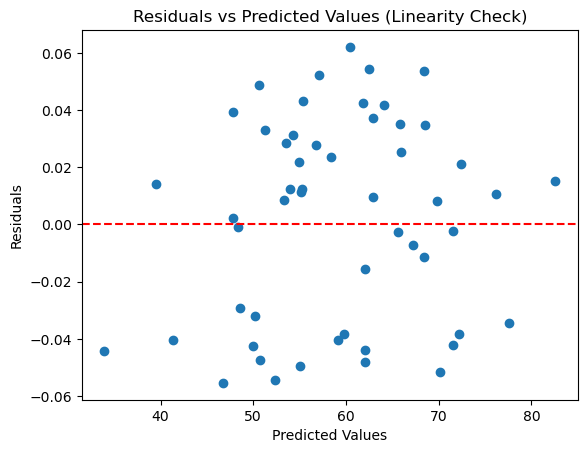

In [37]:
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Linearity Check)')
plt.show()

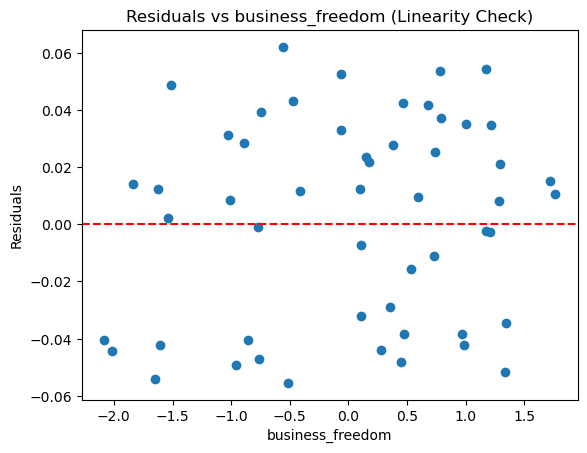

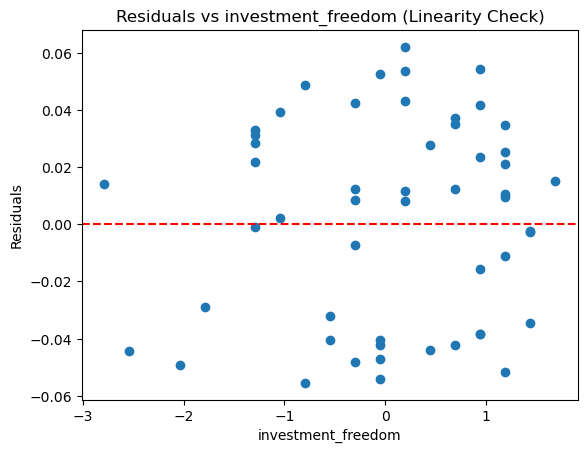

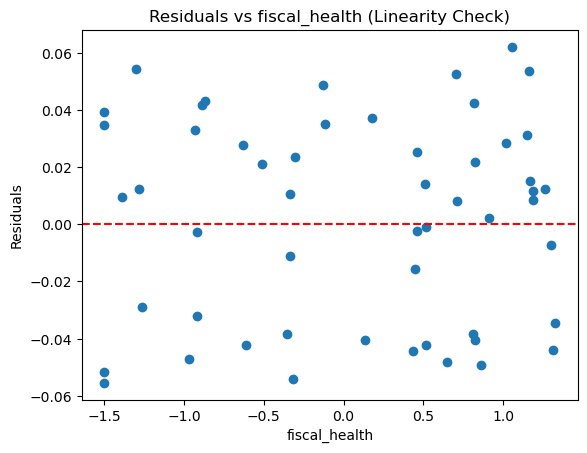

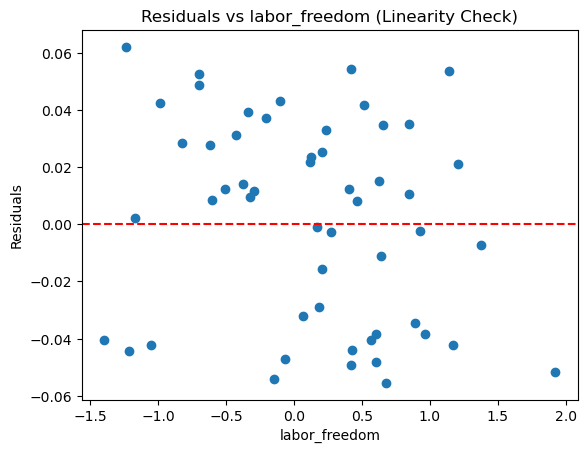

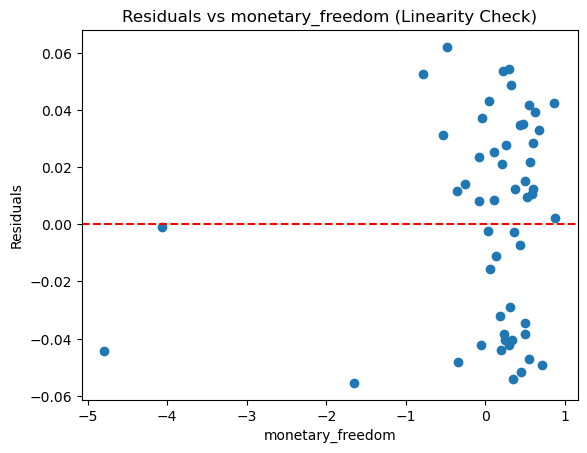

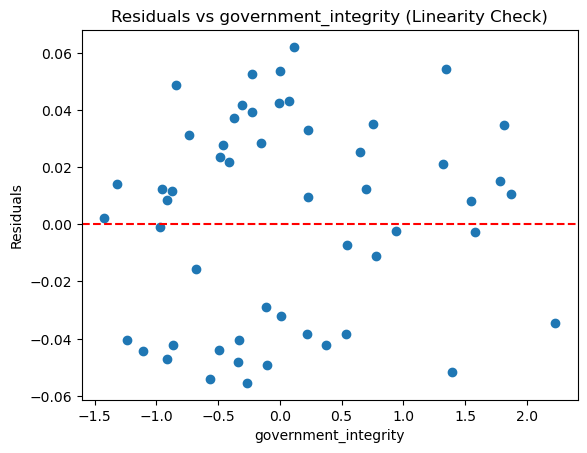

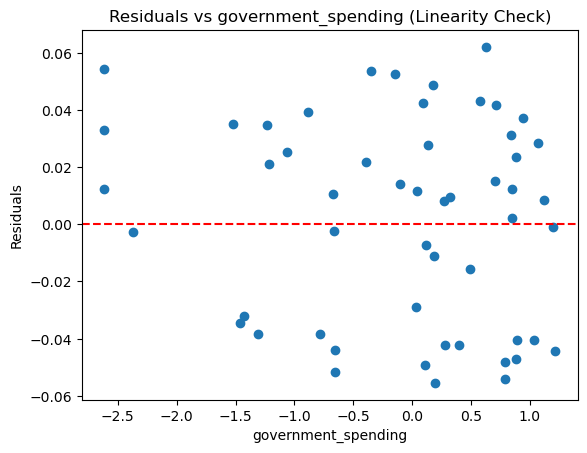

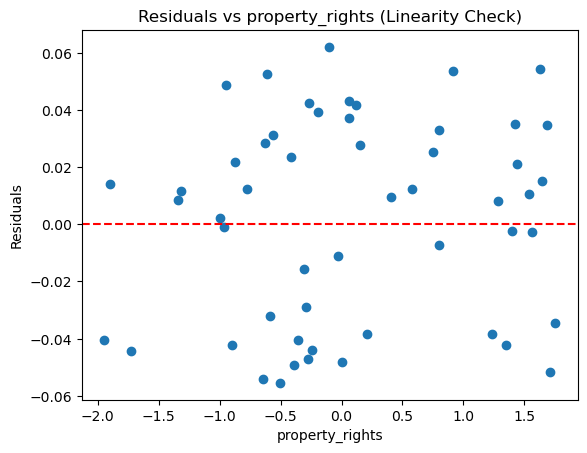

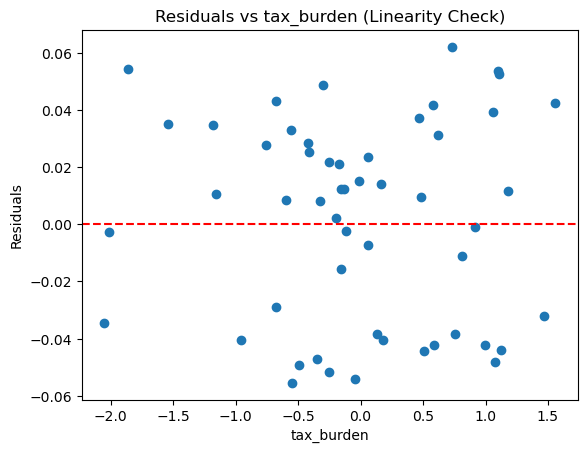

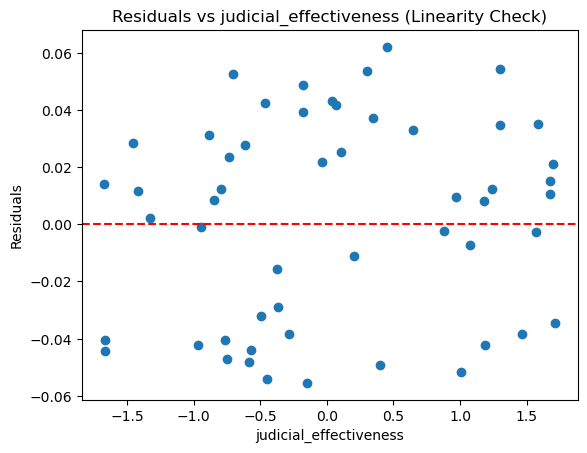

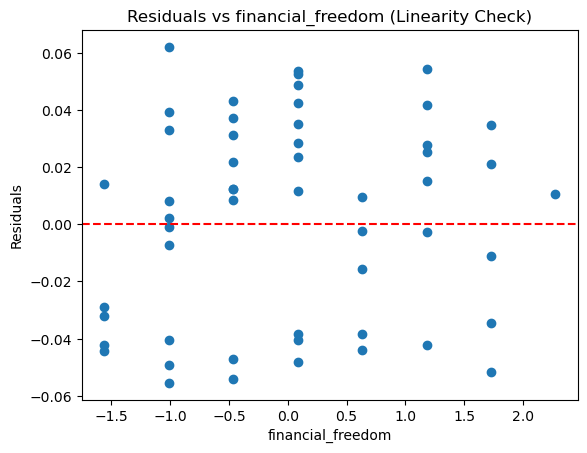

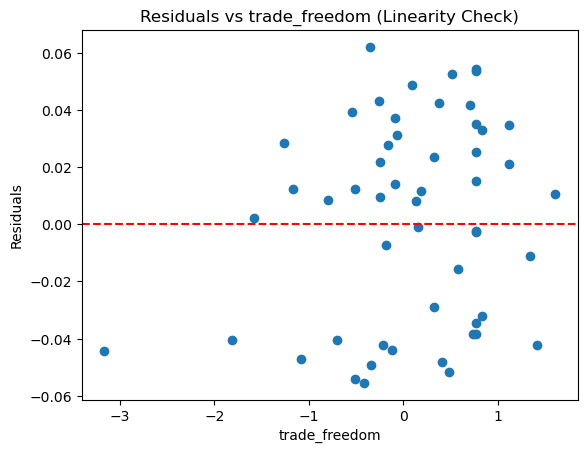

In [38]:
for feature in features:
    plt.scatter(X_test_scale[feature], residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuals vs {feature} (Linearity Check)')
    plt.xlabel(feature)
    plt.ylabel('Residuals')
    plt.show()

#### Independence

In [39]:
dw_test = durbin_watson(residuals)
print(f"Durbin-Watson test statistic: {dw_test}")

Durbin-Watson test statistic: 2.1873708990362153


#### Homoscedasticity

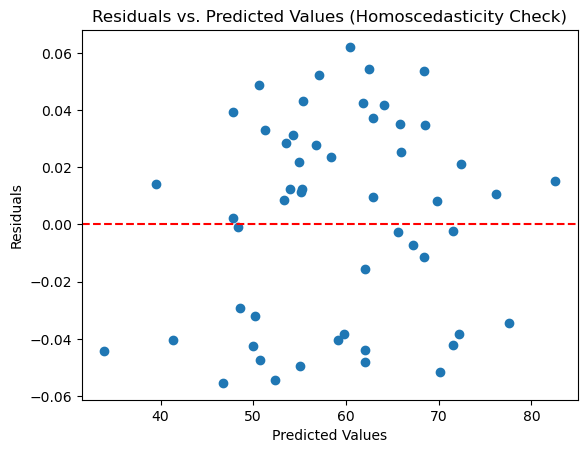

In [40]:
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values (Homoscedasticity Check)')
plt.show()

#### Normality of residuals

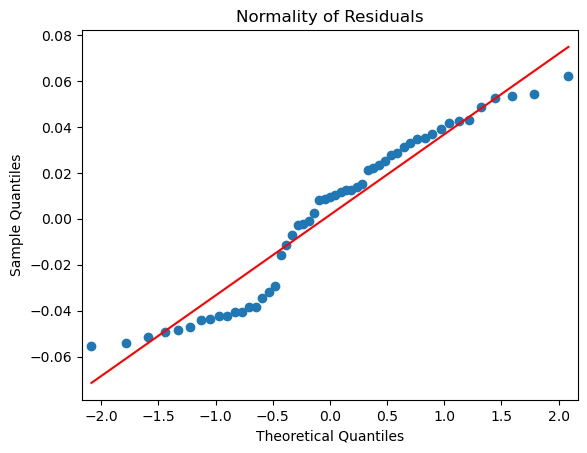

In [41]:
sm.qqplot(residuals, line='s')
plt.title('Normality of Residuals')
plt.show()

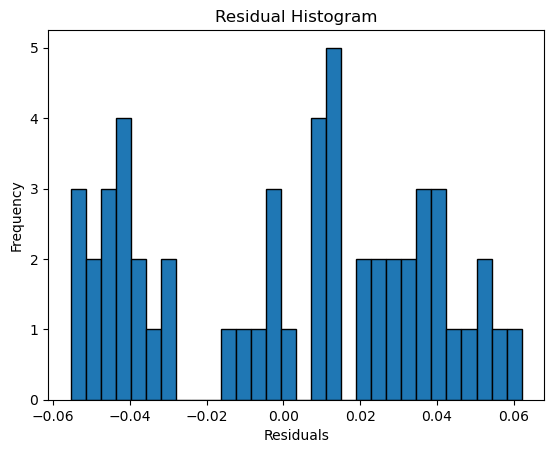

In [42]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [43]:
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test for normality: {shapiro_test}")

Shapiro-Wilk test for normality: ShapiroResult(statistic=0.9271320256911575, pvalue=0.003126934454825416)


#### Multicollinearity

In [44]:
X_vif = sm.add_constant(X_train_scale[features])
vif = pd.DataFrame()
vif['Features'] = X_train_scale[features].columns
vif['VIF'] = [variance_inflation_factor(X_vif, i + 1) for i in range(len(X_train_scale[features].columns))]
print(vif)

                  Features        VIF
0         business_freedom   5.413894
1       investment_freedom   4.080479
2            fiscal_health   1.123713
3            labor_freedom   2.196059
4         monetary_freedom   1.887244
5     government_integrity   8.610661
6      government_spending   1.811943
7          property_rights  10.433500
8               tax_burden   1.644671
9   judicial_effectiveness   6.314338
10       financial_freedom   4.652350
11           trade_freedom   2.271136


### Fix assumption

#### Normality of Residuals

In [45]:
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [46]:
y_train

152    3.899950
128    3.972177
104    4.039536
78     4.117410
36     4.229749
         ...   
71     4.130355
106    4.036009
14     4.302713
92     4.080922
102    4.041295
Name: score, Length: 123, dtype: float64

### Retrain model

#### Feature selection

In [47]:
features = stepwise(X_train, y_train)

Add business_freedom with p-value 1.864528569757219e-21
Add tax_burden with p-value 1.907120582929709e-12
Add monetary_freedom with p-value 5.8823647139111465e-08
Add trade_freedom with p-value 4.179655615383392e-05
Add judicial_effectiveness with p-value 0.00011455925950506953
Add government_spending with p-value 6.82328685702886e-06
Add fiscal_health with p-value 0.0001578095138854652
Add investment_freedom with p-value 0.0008710686407125302
Add labor_freedom with p-value 0.0015327658807631937


In [48]:
X_train = X_train[features]
X_test = X_test[features]

#### Feature engineering

In [49]:
scaler = StandardScaler()

In [50]:
train_index = X_train.index
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_train_scale.index = train_index

In [51]:
X_train

,business_freedom,tax_burden,monetary_freedom,trade_freedom,judicial_effectiveness,government_spending,fiscal_health,investment_freedom,labor_freedom
152,52.9,90.1,62.2,70.8,11.1,58.8,83.6,30.0,46.3
128,60.5,84.3,70.0,58.2,43.7,78.1,68.5,10.0,48.2
104,49.9,83.6,67.5,49.8,27.6,83.7,89.3,60.0,50.0
78,76.9,79.1,77.0,80.2,65.2,54.6,12.4,55.0,50.8
36,79.5,78.9,74.5,75.0,76.9,86.9,44.4,60.0,61.8
...,...,...,...,...,...,...,...,...,...
71,67.2,82.0,70.9,55.2,71.5,78.5,64.7,55.0,64.1
106,54.7,88.8,71.5,70.8,22.0,78.2,74.7,50.0,47.4
14,80.7,76.8,66.5,79.2,74.4,55.5,83.2,70.0,61.8
92,49.0,79.3,60.0,64.4,45.4,84.3,62.5,65.0,47.6


In [52]:
test_index = X_test.index
X_test_scale = pd.DataFrame(scaler.transform(X_test), columns=features)
X_test_scale.index = test_index

#### Model training

In [53]:
model = sm.OLS(y_train, sm.add_constant(X_train_scale)).fit()

In [54]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     97.52
Date:                Fri, 04 Oct 2024   Prob (F-statistic):           4.72e-49
Time:                        15:07:51   Log-Likelihood:                 104.22
No. Observations:                 123   AIC:                            -188.4
Df Residuals:                     113   BIC:                            -160.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4.0535      0.010    415.527      0.000       4.034       4.073
business_freedom           0.0385      0.019      1.991      0.049       0.000       0.077
tax_burden                 0.0821      0.013      6.568      0.000       0.057       0.107
monetary_freedom           0.0477      0.013      3.580      0.001       0.021       0.074
trade_freedom              0.0647      0.015      4.441      0.000       0.036       0.094
judicial_effectiveness     0.0909      0.018      4.923      0.000       0.054       0.128
government_spending        0.0583      0.013      4.616      0.000       0.033       0.083
fiscal_health              0.0471      0.010      4.560      0.000       0.027       0.068
investment_freedom         0.0528      0.014      3.696      0.000       0.024       0.081
labor_freedom              0.0465      0.014      3.248      0.002       0.018       0.075
==============================================================================
Omnibus:                      125.156   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3059.679
Skew:                          -3.309   Prob(JB):                         0.00
Kurtosis:                      26.520   Cond. No.                         4.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
y_pred = model.predict(sm.add_constant(X_test_scale))
residuals = y_test - y_pred

### Recheck assumption

#### Normality of residuals

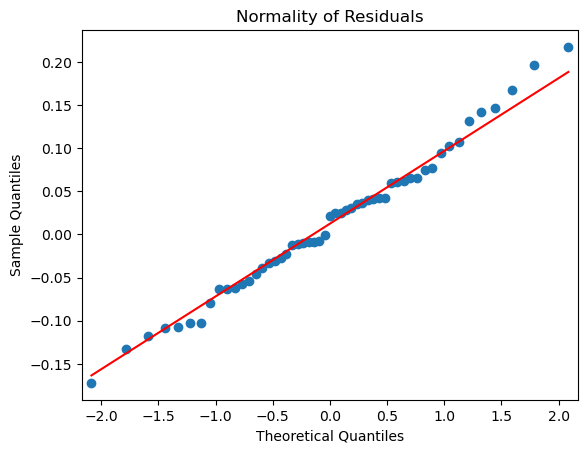

In [56]:
sm.qqplot(residuals, line='s')
plt.title('Normality of Residuals')
plt.show()

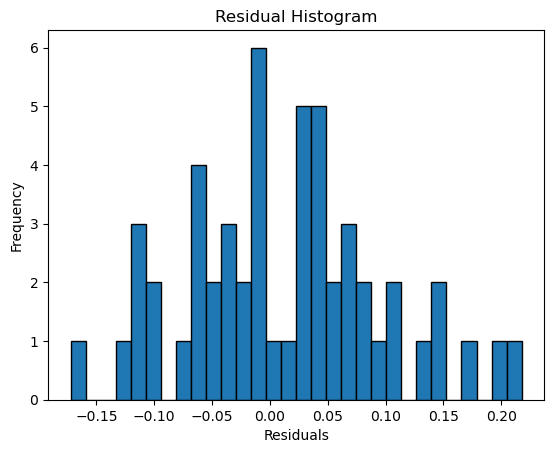

In [57]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [58]:
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk test for normality: {shapiro_test}")

Shapiro-Wilk test for normality: ShapiroResult(statistic=0.9888665754316059, pvalue=0.9008050356360633)


## Evaluate

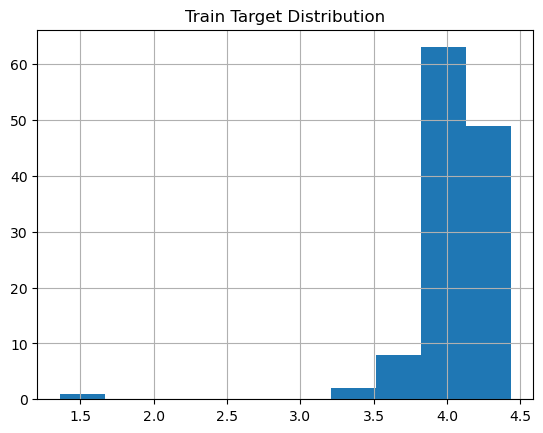

In [59]:
y_train.hist()
plt.title('Train Target Distribution')
plt.show()

In [60]:
y_pred_train = model.predict(sm.add_constant(X_train))
mean_squared_error(y_pred_train, y_train)

1098.343280045775

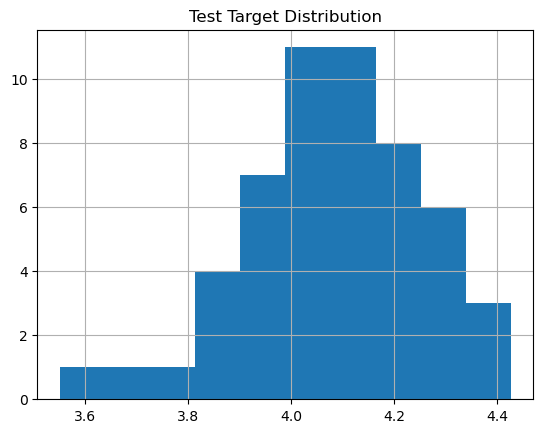

In [61]:
y_test.hist()
plt.title('Test Target Distribution')
plt.show()

In [62]:
mean_squared_error(y_pred, y_test)

0.007282074810855533

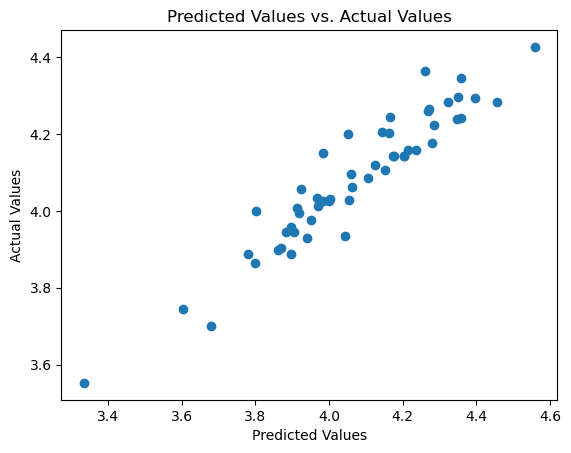

In [63]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Predicted Values vs. Actual Values')
plt.show()

## Test run

In [64]:
input = {
    'business_freedom': 68.5,
    'tax_burden': 68.0,
    'monetary_freedom': 71.1,
    'trade_freedom': 67.4,
    'judicial_effectiveness': 32.9,
    'government_spending': 33.9,
    'fiscal_health': 29.9,
    'investment_freedom': 65.0,
    'labor_freedom': 48.6
}

In [65]:
input_df = pd.DataFrame(input, index=[0])

In [66]:
input_df

,business_freedom,tax_burden,monetary_freedom,trade_freedom,judicial_effectiveness,government_spending,fiscal_health,investment_freedom,labor_freedom
0,68.5,68.0,71.1,67.4,32.9,33.9,29.9,65.0,48.6


In [67]:
input_df = pd.DataFrame(scaler.transform(input_df), columns=features)

In [68]:
input_df

,business_freedom,tax_burden,monetary_freedom,trade_freedom,judicial_effectiveness,government_spending,fiscal_health,investment_freedom,labor_freedom
0,0.378822,-0.756029,0.261349,-0.167476,-0.614176,-1.247868,-0.628133,0.447156,-0.617555


In [69]:
log_result = model.predict(sm.add_constant(input_df, has_constant='add'))

In [70]:
log_result

0    3.844414
dtype: float64

In [71]:
result = np.exp(log_result)

In [72]:
result

0    46.731308
dtype: float64